<a href="https://colab.research.google.com/github/aubricot/object_detection_for_image_cropping/blob/master/COLAB_object_detection_for_image_cropping_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using YOLO in Darkflow to detect birds from images
---
*Last Updated 25 November 2019*   

## Installs
---
Install required libraries directly to this Colab notebook.

In [1]:
# Make sure you are using Python 3.6
# Install packages using pip
!python --version
!pip install tensorflow-gpu==1.15.0rc2
!pip install cython
!pip install opencv-python

Python 3.6.8
     |████████████████████████████████| 411.5MB 37kB/s 


In [2]:
# Download darkflow (the tensorflow implementation of YOLO)
import os
import pathlib


if "darkflow" in pathlib.Path.cwd().parts:
  while "darkflow" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path("darkflow").exists():
  !git clone --depth 1 https://github.com/thtrieu/darkflow.git

Cloning into 'darkflow'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 105 (delta 21), reused 100 (delta 21), pack-reused 0
Receiving objects: 100% (105/105), 16.41 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [3]:
  # Compile darkflow
  %cd darkflow
  !python setup.py build_ext --inplace

/content/darkflow
Compiling darkflow/cython_utils/nms.pyx because it changed.
Compiling darkflow/cython_utils/cy_yolo2_findboxes.pyx because it changed.
Compiling darkflow/cython_utils/cy_yolo_findboxes.pyx because it changed.
[1/3] Cythonizing darkflow/cython_utils/cy_yolo2_findboxes.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/darkflow/darkflow/cython_utils/cy_yolo2_findboxes.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/3] Cythonizing darkflow/cython_utils/cy_yolo_findboxes.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/darkflow/darkflow/cython_utils/cy_yolo_findboxes.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[3/3] Cythonizing darkflow/cython_u

In [4]:
# Change darkflow to darkflow-master to distinguish between folder names
%cd ../
!mv darkflow darkflow-master

/content


In [5]:
# (Optional) Mount google drive to export detection results as tsv
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

### Imports   
---

In [7]:
%cd darkflow-master

%tensorflow_version 1.15.0rc2 # test with -gpu
import tensorflow as tf
print(tf.__version__)

# For importing/exporting files, working with arrays, etc
import pathlib
import time
import csv
import urllib
import numpy as np
import pandas as pd

# For the actual object detection
from darkflow.net.build import TFNet

# For drawing onto and plotting the images
import matplotlib.pyplot as plt
import cv2

%config InlineBackend.figure_format = 'svg'

/content/darkflow-master
`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15.0rc2 # test with -gpu`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.0-rc2
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




### Model Preparation
---   
**Uploads**: The models are already in darkflow/cfg, but the pre-trained weights associated with these models need to be uploaded to this notebook from https://drive.google.com/drive/folders/0B1tW_VtY7onidEwyQ2FtQVplWEU. 

**"Flowing" images through the model**: Ignore the warning messages about deprecated names, they still work at the time this last updated. Code for parameters is based on https://github.com/thtrieu/darkflow ("Using darkflow from another python application").

Your output should be a table of values like those shown below:

Source | Train? | Layer description                | Output size
------- |:--------:|:----------------------------------:| ---------------
       |        | input                            | (?, 448, 448, 3)
 Load  |  Yep!  | scale to (-1, 1)                 | (?, 448, 448, 3)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 448, 448, 16)

**Define boxing function**: You can adjust the parameters so that bounding boxes are only shown for certain confidence or class values. Here boxes are shown when confidence > 0.3 and object class is 'bird'. This function is modified from here https://gist.github.com/deep-diver/40f092ad56525189674a86b6fde6d304.

In [8]:
# Upload pre-trained weights file from Google drive
# For directions to upload other weights files, see the wiki for this repository
import os

weights = 'yolo-tiny'
weights_file = weights + '.weights'
if not os.path.exists('weights_file'):
  !gdown --id 0B1tW_VtY7onibmdQWE1zVERxcjQ
  !mkdir bin
  !mv yolo-tiny.weights bin

Downloading...
From: https://drive.google.com/uc?id=0B1tW_VtY7onibmdQWE1zVERxcjQ
To: /content/darkflow-master/yolo-tiny.weights
180MB [00:03, 55.1MB/s]


In [9]:
# Upload yolo-tiny.cfg model from Google Drive
# File from https://github.com/cvjena/darknet/blob/master/cfg/yolo-tiny.cfg
model = 'yolo-tiny'
weights_file = weights + '.cfg'
if not os.path.exists('weights_file'):
  !gdown --id 1iWZqM7c1APk36FeQwDq9wiX8YCqClhTi
  !mv yolo-tiny.cfg cfg

Downloading...
From: https://drive.google.com/uc?id=1iWZqM7c1APk36FeQwDq9wiX8YCqClhTi
To: /content/darkflow-master/yolo-tiny.cfg
100% 1.49k/1.49k [00:00<00:00, 1.04MB/s]


In [10]:
# Test installation, you should see an output with different parameters for flow
%cd darkflow-master
!pwd
!python flow --h

[Errno 2] No such file or directory: 'darkflow-master'
/content/darkflow-master
/content/darkflow-master
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Example usage: flow --imgdir sample_img/ --model cfg/yolo.cfg --load bin/yolo.weights

Arguments:
  --help, --h, -h  show this super helpful message and exit
  --imgdir         path to testing directory with images
  --binary         path to .weights directory
  --config         path to .cfg directory
  --dataset        path to dataset directory
  --labels         path to labels file
  --backup         path to backup folder
  --summary        path to TensorBoard summaries directory
  --annotation     path to annotation dire

In [12]:
# Define parameters for "flow"ing the images through the model
params = {
    'model': 'cfg/yolo-tiny.cfg',
    'load': 'bin/yolo-tiny.weights',
    'threshold': 0.3,
    'gpu': 1.0
}

# Run the model
tfnet = TFNet(params)

Parsing ./cfg/yolo-tiny.cfg
Parsing cfg/yolo-tiny.cfg
Loading bin/yolo-tiny.weights ...
Successfully identified 180357512 bytes
Finished in 0.004238605499267578s
Model has a VOC model name, loading VOC labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 448, 448, 3)
 Load  |  Yep!  | scale to (-1, 1)                 | (?, 448, 448, 3)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 448, 448, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 224, 224, 16)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 224, 224, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 112, 112, 32)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 112, 112, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 56, 56, 64)
 Load  |  Yep!  | conv 3x3p1_1    leaky            | (?, 56, 56, 128)
 Load

In [0]:
# For uploading an image from url
# Modified from https://www.pyimagesearch.com/2015/03/02/convert-url-to-image-with-python-and-opencv/
def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
  return image

In [0]:
# For drawing bounding boxes around detected objects on images
def boxing(image, predictions):
    newImage = np.copy(image)
    im_height, im_width, im_depth = image.shape
        
    for result in predictions:
        xmin = result['topleft']['x']
        ymin = result['topleft']['y']

        xmax = result['bottomright']['x']
        ymax = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))

        # only show boxes that are above .3 confidence and for the label, bird
        if confidence > 0.3 and result['label'] == 'bird' :
            # draw boxes on images
            fontScale = min(im_width,im_height)/(600)
            newImage = cv2.rectangle(newImage, (xmin, ymax), (xmax, ymin), (255,0,0), 3)
            newImage = cv2.putText(newImage, label, (xmin, ymax-5), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 230, 0), 7, cv2.LINE_AA)

            # optional: if mounted to drive, export detection results to sample_crops_yolo.tsv
            # must make empty sample_crops_yolo.tsv file in your drive first and paste the path to it below
            if os.path.exists('/content/drive/My Drive/fall19_smithsonian_informatics/sample_crops_yolo.tsv'):
              with open('/content/drive/My Drive/fall19_smithsonian_informatics/sample_crops_yolo.tsv', 'a') as out_file:
                  tsv_writer = csv.writer(out_file, delimiter='\t')
                  crop_width = xmax-xmin
                  crop_height = ymax-ymin
                  tsv_writer.writerow([image_url, im_height, im_width, 
                            xmin, ymin, crop_height, crop_width])
            
        else:
          print("No detections found.")
    return newImage

## Load in sample images and "flow" images through object detector
---
You can either **A) Load individual images in by URL**, or for large image batches or **B) Load multiple images from a text file of image URLs**. Other methods for importing to Google Colab are listed [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd). 

**A) Load individual images in by URL**
Load in images by URL and run the image detector for all images. Plotted results include the image with bounding box around detected objects (birds), class type, and confidence score. Inference times are printed below images. If you "mounted" your Google Drive during "Installs", the bounding box coordinates will also be written to 'sample_crops_yolo.tsv'.

In [0]:
image_urls = ["https://content.eol.org/data/media/7e/9c/7a/542.15445377044.jpg",
              "https://content.eol.org/data/media/81/1c/0d/542.7816025222.jpg",
              "https://content.eol.org/data/media/7e/3c/0b/542.10578857864.jpg"]

Inference time: 0.029619932174682617
Inference time: 0.027720212936401367
Inference time: 0.027808666229248047


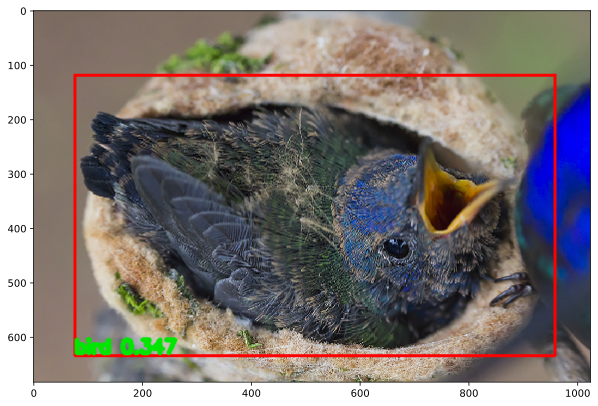

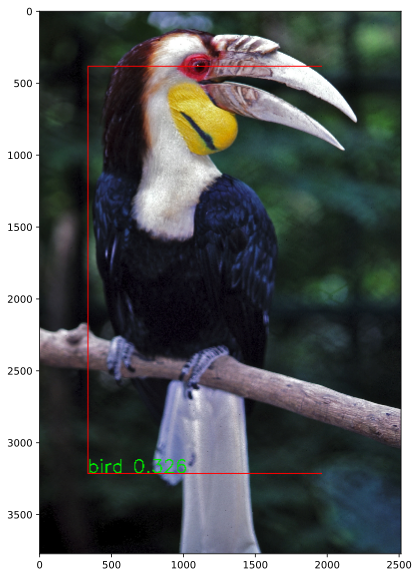

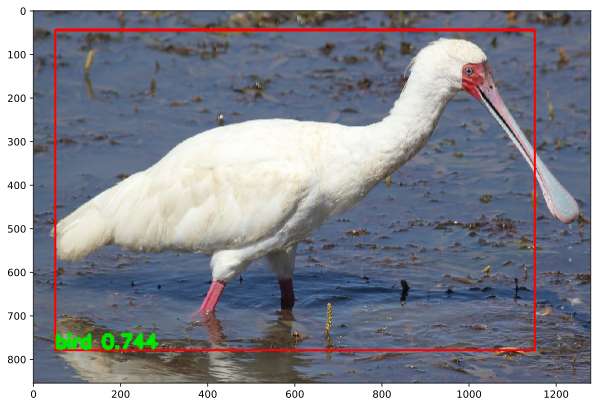

In [18]:
for image_url in image_urls:
  image = url_to_image(image_url)

  # Use YOLO for object detection  
  # Record inference time
  start_time = time.time()
  result = tfnet.return_predict(image)
  end_time = time.time()
  print("Inference time:", end_time-start_time)

  # Plot and show detection boxes on images
  _, ax = plt.subplots(figsize=(10, 10))
  ax.imshow(boxing(image, result))

**B) Load multiple images from a text file of image URLs**
Load in multiple images from a text file of URLS and run the image detector for all images. Plotted results include the image with bounding box around detected objects (birds), class type, and confidence score. Inference times are printed below images. If you "mounted" your Google Drive during "Installs", the bounding box coordinates will also be written to 'sample_crops_yolo.tsv'.

In [20]:
urls = 'https://editors.eol.org/other_files/bundle_images/files/images_for_Aves_breakdown_download_000001.txt'
df1 = pd.read_csv(urls)
df1.columns = ["link"]
pd.DataFrame.head(df1)

,link
0,https://content.eol.org/data/media/9d/02/38/53...
1,https://content.eol.org/data/media/9c/e8/f2/53...
2,https://content.eol.org/data/media/9c/ef/07/53...
3,https://content.eol.org/data/media/9c/d7/5a/53...
4,https://content.eol.org/data/media/9d/08/d7/53...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Inference time: 0.4675593376159668
Inference time: 0.44824767112731934
Inference time: 0.44275951385498047
Inference time: 0.4471893310546875
Inference time: 0.44705772399902344


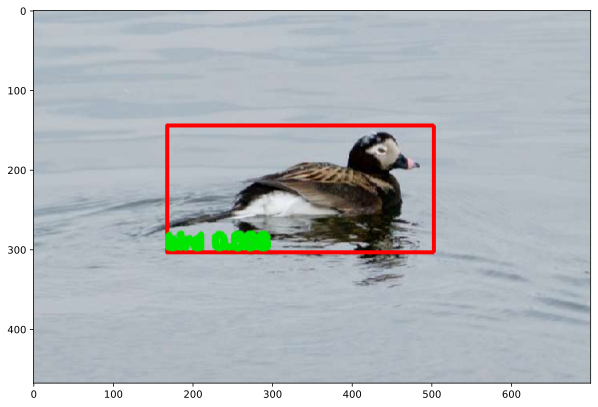

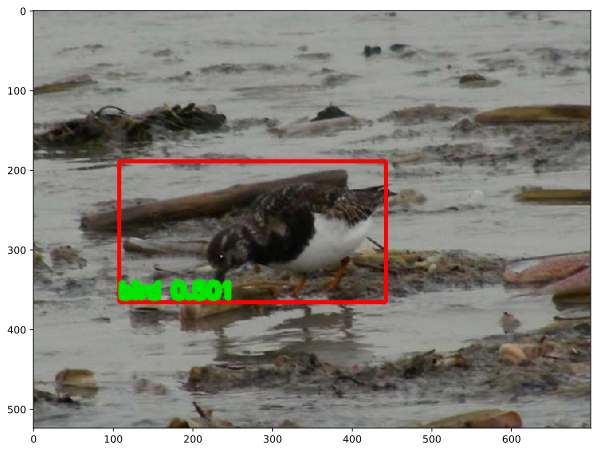

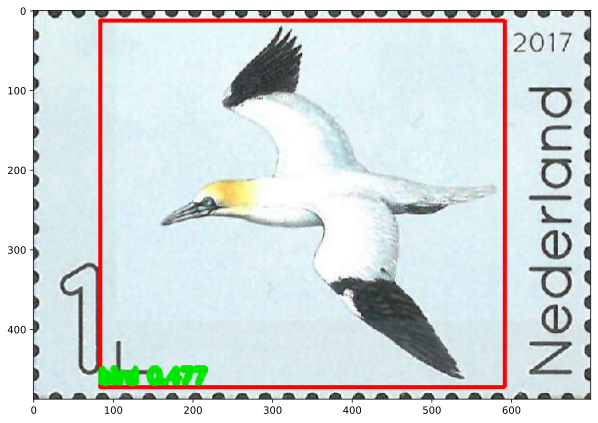

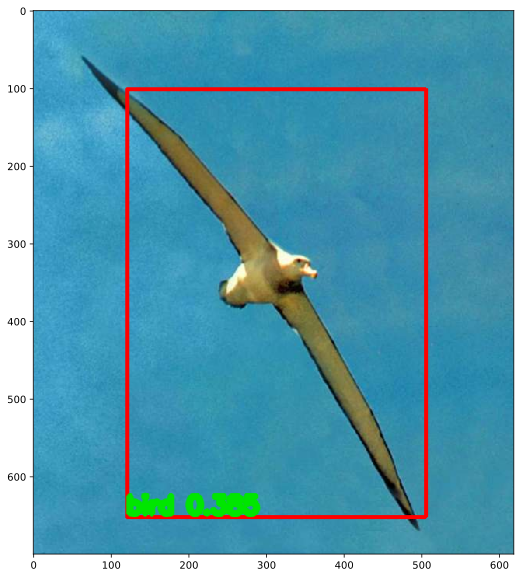

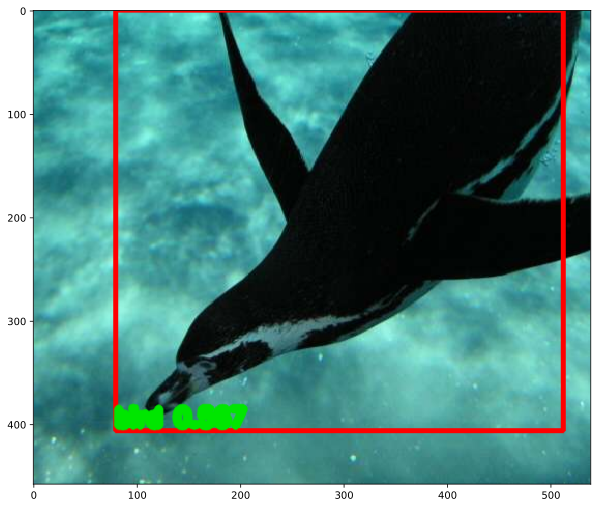

In [21]:
# Loops through first 5 image urls from the text file
for i, row in df1.head(5).itertuples(index=True, name='Pandas'):
  
  # Use YOLO for object detection  
  # Record inference time
  start_time = time.time()
  image_url = df1.get_value(i, "link")
  image = url_to_image(image_url)

  result = tfnet.return_predict(image)
  end_time = time.time()
  print("Inference time:", end_time-start_time)

  # Plot and show detection boxes on images
  _, ax = plt.subplots(figsize=(10, 10))
  ax.imshow(boxing(image, result))